Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


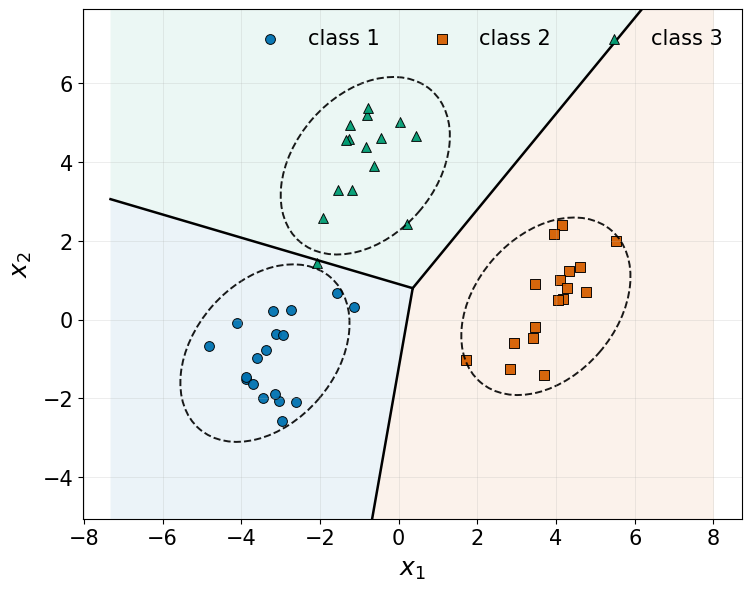

In [6]:
# LDA: 3 classes — dashed ellipses, faint regions, clipped decision boundaries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

rng = np.random.default_rng(7)

# ----- controls -----
C, n, separation = 3, 50, 1.7

# Okabe–Ito color-blind–friendly palette
OKABE_ITO = ["#0072B2", "#D55E00", "#009E73", "#CC79A7", "#56B4E9",
             "#E69F00", "#000000", "#F0E442"]
colors  = OKABE_ITO[:C]
markers = ["o", "s", "^"]

# ----- LDA generative parameters -----
pi = np.repeat(1.0/C, C)
base_mus = np.array([[-2.0, -0.5],
                     [ 2.2,  0.2],
                     [-0.5,  2.3]], dtype=float)
mus = base_mus * separation
Sigma = np.array([[1.0, 0.35],
                  [0.35, 1.1]])
Sigma_inv = np.linalg.inv(Sigma)

# sample
ys = rng.choice(C, size=n, p=pi)
X  = np.vstack([rng.multivariate_normal(mus[c], Sigma) for c in ys])

# δ_c(x) = w_c^T x + b_c
w = (Sigma_inv @ mus.T).T
b = -0.5 * np.sum(mus @ Sigma_inv * mus, axis=1) + np.log(pi)

# pairwise boundary: (w_i - w_j)^T x + (b_i - b_j) = 0
def line_normal_and_offset(i, j):
    return w[i] - w[j], b[i] - b[j]

# intersection of two lines n1^T x + c1 = 0, n2^T x + c2 = 0
def intersect(n1, c1, n2, c2):
    A = np.vstack([n1, n2])
    Cvec = -np.array([c1, c2])
    return np.linalg.solve(A, Cvec)

# common intersection
n01, c01 = line_normal_and_offset(0, 1)
n02, c02 = line_normal_and_offset(0, 2)
P = intersect(n01, c01, n02, c02)

# plotting bounds
pad = 2.5
xmin, xmax = X[:,0].min()-pad, X[:,0].max()+pad
ymin, ymax = X[:,1].min()-pad, X[:,1].max()+pad

# faint decision regions
xx, yy = np.meshgrid(np.linspace(xmin, xmax, 400),
                     np.linspace(ymin, ymax, 400))
grid = np.c_[xx.ravel(), yy.ravel()]
g = grid @ w.T + b
pred = g.argmax(axis=1).reshape(xx.shape)

def cov_ellipse(mean, cov, k=2.0, **kwargs):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    width, height = 2 * k * np.sqrt(vals)
    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
    return Ellipse(xy=mean, width=width, height=height, angle=angle, **kwargs)

def ray_extent_from_point(P, d, xlim, ylim):
    ts = []
    if abs(d[0]) > 1e-12:
        ts += [(xlim[0]-P[0])/d[0], (xlim[1]-P[0])/d[0]]
    if abs(d[1]) > 1e-12:
        ts += [(ylim[0]-P[1])/d[1], (ylim[1]-P[1])/d[1]]
    ts_pos = [t for t in ts if t > 0]
    return 0.0 if not ts_pos else min(ts_pos)

# ---- figure ----
plt.rcParams.update({
    "font.size": 16,          # base font
    "axes.titlesize": 18,
    "axes.labelsize": 18,
    "legend.fontsize": 15,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
})

fig, ax = plt.subplots(figsize=(7.4, 5.8), constrained_layout=True)

# faint regions
region_cmap = plt.matplotlib.colors.ListedColormap(colors)
ax.contourf(xx, yy, pred, levels=np.arange(C+1)-0.5,
            cmap=region_cmap, alpha=0.08, antialiased=True)

# samples
for c in range(C):
    idx = (ys == c)
    ax.scatter(X[idx, 0], X[idx, 1],
               s=50, c=colors[c], marker=markers[c],
               edgecolors="black", linewidths=0.7, alpha=0.95,
               label=f"class {c+1}")  # start from 1

# dashed ellipses
for c in range(C):
    ax.add_patch(cov_ellipse(mus[c], Sigma, k=2.15,
                             edgecolor="black", facecolor="none",
                             lw=1.4, alpha=0.9, linestyle="--"))

# decision boundaries as clipped half-lines
pairs = [(0,1), (0,2), (1,2)]
for (i, j) in pairs:
    no, c = line_normal_and_offset(i, j)
    d = np.array([-no[1], no[0]], dtype=float)
    d /= np.linalg.norm(d) + 1e-12
    k = ({0,1,2} - {i,j}).pop()
    if (w[k]-w[i]) @ d > 0 or (w[k]-w[j]) @ d > 0:
        d = -d
    tmax = ray_extent_from_point(P, d, (xmin, xmax), (ymin, ymax))
    Q = P + tmax * d
    ax.plot([P[0], Q[0]], [P[1], Q[1]], color="black", linewidth=1.8)

# aesthetics
ax.set_xlabel("$x_1$", labelpad=6)
ax.set_ylabel("$x_2$", labelpad=6)
ax.legend(frameon=False, ncol=3, loc="upper right")
ax.axis("equal")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.grid(True, linewidth=0.4, alpha=0.4)
plt.savefig('sample.png', dpi=600)

step  500 | nll=3.8393
step 1000 | nll=3.8393
step 1500 | nll=3.8393
step 2000 | nll=3.8393


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


step 2500 | nll=3.8393
--- Parameter comparison: gradient ML vs. closed-form MLE ---
||Δπ||_1   = 2.9802322387695312e-08
||Δμ||_F   = 0.00044810639797807615
||ΔΣ||_F   = 0.00029409350177942947


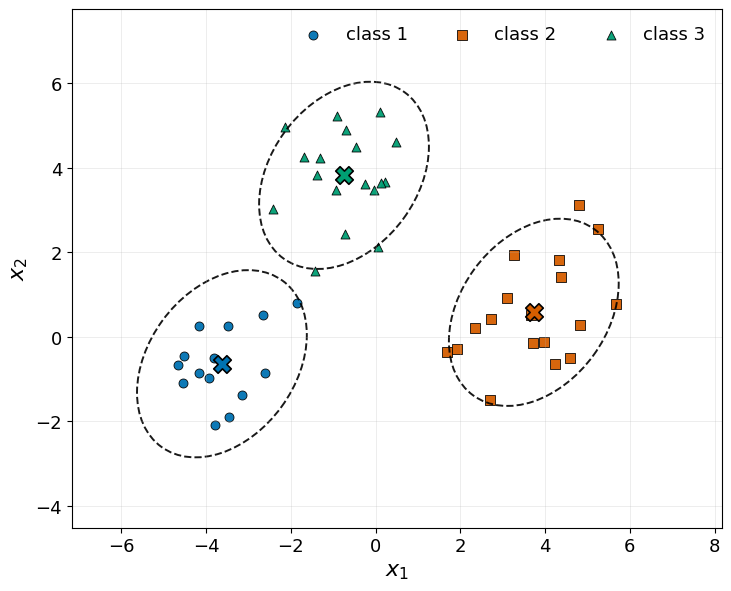

In [7]:
# Figure 2 — Gradient-based ML for classical LDA (n = 50)
# Shows optimizer (Adam) recovers the closed-form MLE.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import torch
import torch.nn.functional as F

rng = np.random.default_rng(0)

# ----------------------------
# 1) Synthetic LDA data (d=2, C=3)
#    Use the parameters defined in the first cell.
# ----------------------------
C = pi.shape[0]
d = mus.shape[1]

pi_true = pi
mus_true = mus
Sigma_true = Sigma

ys = rng.choice(C, size=n, p=pi_true)
X  = np.vstack([rng.multivariate_normal(mus_true[c], Sigma_true) for c in ys])

# ----------------------------
# 2) Closed-form MLE for LDA
# ----------------------------
def lda_mle_closed_form(X, y, C):
    n, d = X.shape
    pi_hat = np.array([(y == c).mean() for c in range(C)])
    mus_hat = np.vstack([X[y == c].mean(axis=0) for c in range(C)])
    # pooled covariance
    S = np.zeros((d, d))
    for c in range(C):
        Xc = X[y == c]
        Z  = Xc - mus_hat[c]
        S += Z.T @ Z
    S /= n
    return pi_hat, mus_hat, S

pi_mle_cf, mu_mle_cf, Sigma_mle_cf = lda_mle_closed_form(X, ys, C)

# ----------------------------
# 3) Gradient-based ML with Adam (unconstrained reparam)
#    π = softmax(α), Σ = L L^T with exp(diag) for positivity
# ----------------------------
device = "cpu"
Xt = torch.tensor(X, dtype=torch.float32, device=device)
yt = torch.tensor(ys, dtype=torch.long, device=device)

# Params: logits for priors, free means, lower-tri L (diag in log-domain)
alpha = torch.zeros(C, requires_grad=True)                                # π = softmax(α)
mu    = torch.tensor(mu_mle_cf + 0.2*rng.standard_normal(mu_mle_cf.shape),
                    dtype=torch.float32, requires_grad=True)
L_free = torch.zeros(d, d, dtype=torch.float32)                           # store strictly lower part
log_diag = torch.zeros(d, dtype=torch.float32, requires_grad=True)        # diag(L) = exp(log_diag)
L_free = torch.nn.Parameter(L_free, requires_grad=True)
log_diag = torch.nn.Parameter(log_diag, requires_grad=True)

opt = torch.optim.Adam([alpha, mu, L_free, log_diag], lr=5e-2)

def make_cholesky(L_free, log_diag):
    L = torch.tril(L_free).clone()
    idx = torch.arange(L.shape[0])
    L[idx, idx] = torch.exp(log_diag)          # positive diagonal
    return L

def logpdf_gauss_shared(x, mu_c, L):
    # x: [n,d], mu_c: [C,d], L: [d,d] lower-triangular Cholesky factor
    n, d = x.shape
    C = mu_c.shape[0]
    Sigma_logdet = 2.0 * torch.log(torch.diagonal(L)).sum()

    # Compute Mahalanobis distances efficiently
    # For each class c, solve v = L^{-1}(x - mu_c)
    invL = torch.inverse(L)
    diff = x[:, None, :] - mu_c[None, :, :]              # [n,C,d]
    v = diff @ invL.T                                   # [n,C,d]
    quad = (v ** 2).sum(dim=2)                          # [n,C]

    return -0.5 * (d * np.log(2 * np.pi) + Sigma_logdet + quad)


def nll_batch(x, y, alpha, mu, L):
    pi_log = F.log_softmax(alpha, dim=0)                                   # log π_c
    lp = logpdf_gauss_shared(x, mu, L) + pi_log                            # [n,C]
    # average negative log-likelihood
    return -(lp[torch.arange(x.shape[0]), y].mean())

# Train
steps = 2500
for t in range(steps):
    L = make_cholesky(L_free, log_diag)
    loss = nll_batch(Xt, yt, alpha, mu, L)
    opt.zero_grad(set_to_none=True)
    loss.backward()
    opt.step()
    if (t+1) % 500 == 0:
        print(f"step {t+1:4d} | nll={loss.item():.4f}")

# Extract learned parameters
with torch.no_grad():
    pi_ml = F.softmax(alpha, dim=0).cpu().numpy()
    mu_ml = mu.cpu().numpy()
    L_ml  = make_cholesky(L_free, log_diag).cpu().numpy()
    Sigma_ml = L_ml @ L_ml.T

print("--- Parameter comparison: gradient ML vs. closed-form MLE ---")
print("||Δπ||_1   =", np.abs(pi_ml - pi_mle_cf).sum())
print("||Δμ||_F   =", np.linalg.norm(mu_ml - mu_mle_cf))
print("||ΔΣ||_F   =", np.linalg.norm(Sigma_ml - Sigma_mle_cf))

# ----------------------------
# 4) Plot: data + ellipses (solid = grad-ML, dashed = closed-form MLE)
# ----------------------------
OKABE_ITO = ["#0072B2", "#D55E00", "#009E73"]
colors = OKABE_ITO[:C]
markers = ["o", "s", "^"]

def cov_ellipse(mean, cov, k=2.0, **kwargs):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    width, height = 2 * k * np.sqrt(vals)
    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
    return Ellipse(xy=mean, width=width, height=height, angle=angle, **kwargs)

plt.rcParams.update({
    "font.size": 14, "axes.labelsize": 16, "legend.fontsize": 13,
    "xtick.labelsize": 13, "ytick.labelsize": 13
})
fig, ax = plt.subplots(figsize=(7.2, 5.8), constrained_layout=True)

# scatter by class (labels start from 1)
for c in range(C):
    idx = (ys == c)
    ax.scatter(X[idx,0], X[idx,1], s=42, c=colors[c], marker=markers[c],
               edgecolors="black", linewidths=0.6, alpha=0.95, label=f"class {c+1}")

# Gradient-ML ellipses (solid)
for c in range(C):
    e = cov_ellipse(mu_ml[c], Sigma_ml, k=2.15,
                    edgecolor="black", facecolor="none",
                    lw=1.4, linestyle="--", alpha=0.9)
    ax.add_patch(e)

# --- class centers ---
for c in range(C):

    # Gradient-ML center (matches solid ellipse): filled "X" in class color
    ax.scatter(mu_ml[c, 0], mu_ml[c, 1],
               s=160, marker="X", c=colors[c],
               edgecolors="black", linewidths=1.2, zorder=7)


ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.legend(frameon=False, ncol=3, loc="upper right")
ax.axis("equal")
pad = 2.5
xmin, xmax = X[:,0].min()-pad, X[:,0].max()+pad
ymin, ymax = X[:,1].min()-pad, X[:,1].max()+pad
ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
ax.grid(True, linewidth=0.4, alpha=0.4)
plt.savefig('gd_mle.png', dpi=600)


## Fisher eigenproblem training
Solve the generalized eigenproblem for between- vs. within-class scatter and
build the resulting LDA classifier parameters.


In [8]:
# Fisher eigenproblem solution (classical LDA)
# Reuses X, ys from above (d=2, C=3).

def fisher_eig_lda(X, y, C):
    n, d = X.shape
    # class priors and means
    counts = np.array([(y == c).sum() for c in range(C)], dtype=float)
    pi_hat = counts / counts.sum()
    mu_c = np.vstack([X[y == c].mean(axis=0) for c in range(C)])
    mu_global = np.sum(pi_hat[:, None] * mu_c, axis=0)

    # within- and between-class scatter
    Sw = np.zeros((d, d))
    Sb = np.zeros((d, d))
    for c in range(C):
        Xc = X[y == c]
        centered = Xc - mu_c[c]
        Sw += centered.T @ centered
        delta = (mu_c[c] - mu_global).reshape(d, 1)
        Sb += counts[c] * (delta @ delta.T)

    # generalized eigenproblem: Sb v = lambda Sw v
    eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(Sw) @ Sb)
    order = eigvals.argsort()[::-1]
    eigvals = eigvals[order].real
    eigvecs = eigvecs[:, order].real
    W = eigvecs[:, : max(1, C-1)]  # projection to discriminant subspace
    return pi_hat, mu_c, Sw / n, W, eigvals

pi_f, mu_f, Sigma_within, W, eigvals = fisher_eig_lda(X, ys, C)
Sigma_inv = np.linalg.pinv(Sigma_within)

# Discriminant parameters from Fisher solution (same form as closed-form LDA)
w_fisher = (Sigma_inv @ mu_f.T).T
b_fisher = -0.5 * np.sum(mu_f @ Sigma_inv * mu_f, axis=1) + np.log(pi_f + 1e-12)

pred_fisher = (X @ w_fisher.T + b_fisher).argmax(axis=1)
acc_fisher = (pred_fisher == ys).mean()

print("top eigenvalues (between/within):", eigvals[:C-1])
print(f"Fisher-eig classifier accuracy on training data: {acc_fisher:.3f}")


top eigenvalues (between/within): [11.52161848  3.24325568]
Fisher-eig classifier accuracy on training data: 1.000


### Visualize Fisher-eig decision regions
Show the decision boundaries implied by the Fisher eigenproblem classifier.


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


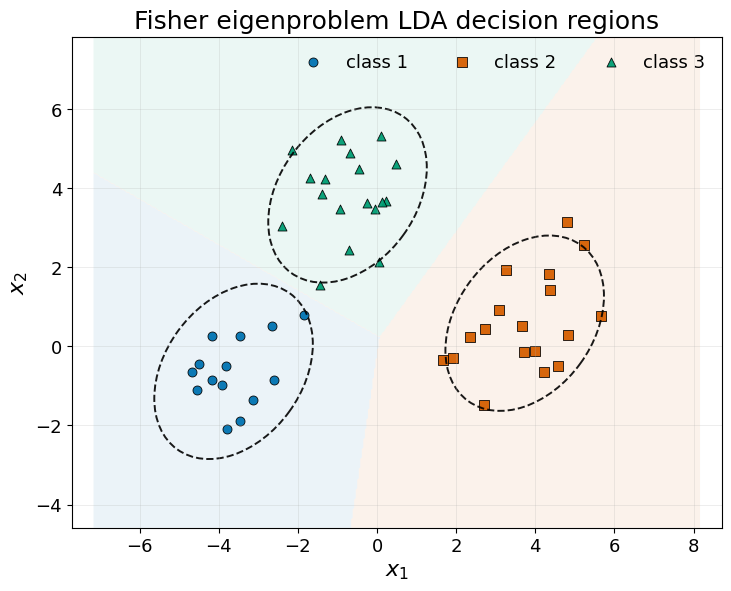

In [9]:
# Decision regions for Fisher-eig LDA
xx, yy = np.meshgrid(np.linspace(X[:,0].min()-2.5, X[:,0].max()+2.5, 400),
                     np.linspace(X[:,1].min()-2.5, X[:,1].max()+2.5, 400))
grid = np.c_[xx.ravel(), yy.ravel()]
g = grid @ w_fisher.T + b_fisher
pred = g.argmax(axis=1).reshape(xx.shape)

colors = OKABE_ITO[:C]
markers = ["o", "s", "^"]

fig, ax = plt.subplots(figsize=(7.2, 5.8), constrained_layout=True)
region_cmap = plt.matplotlib.colors.ListedColormap(colors)
ax.contourf(xx, yy, pred, levels=np.arange(C+1)-0.5,
            cmap=region_cmap, alpha=0.08, antialiased=True)

for c in range(C):
    idx = (ys == c)
    ax.scatter(X[idx,0], X[idx,1], s=42, c=colors[c], marker=markers[c],
               edgecolors="black", linewidths=0.6, alpha=0.95, label=f"class {c+1}")

    # plot within-class covariance ellipse centered at class mean
    e = Ellipse(xy=mu_f[c], width=0, height=0)
    cov = Sigma_within
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    width, height = 2 * 2.15 * np.sqrt(np.maximum(vals, 1e-12))
    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
    ellipse = Ellipse(xy=mu_f[c], width=width, height=height, angle=angle,
                      edgecolor="black", facecolor="none", lw=1.4, linestyle="--", alpha=0.9)
    ax.add_patch(ellipse)

ax.set_title("Fisher eigenproblem LDA decision regions")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.legend(frameon=False, ncol=3, loc="upper right")
ax.axis("equal")
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.grid(True, linewidth=0.4, alpha=0.4)
plt.savefig('fisher_eig_boundaries.png', dpi=600)
